# **MODELADO IMÁGENES**

In [7]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Escoger modelo prenetrenado: ResNet50**

La elección del modelo debe centrarse en cómo las imágenes aportan valor predictivo adicional al modelo tabular.

**Imágenes de interiores:**
Representan detalles como acabados, tamaño percibido, iluminación, y calidad del espacio.

**Datos tabulares:**
Ofrecen información objetiva como tamaño, ubicación, y características técnicas.

***Modelos utilizados en Modelos similares***

En la literatura y proyectos reales de predicción de precios inmobiliarios, EfficientNet y ResNet son las opciones más comunes. Aquí están las razones basadas en estudios y casos previos:


**A. EfficientNet (B0 a B3):**

Utilizado en proyectos como Zillow y aplicaciones similares, donde la calidad visual de los inmuebles es crucial.

Ventajas específicas:
Captura patrones visuales clave (acabados de lujo, espacios modernos).
Excelente relación entre precisión y uso de recursos.

Pre-entrenamiento:
Trained on ImageNet, lo cual es generalista pero capta texturas y patrones relevantes para interiores.


**B. ResNet (ResNet50):**
Generalista probado:
Muy utilizado en tareas generales, incluyendo propiedades inmobiliarias en estudios académicos.

Ventajas específicas:
Extrae características visuales robustas de imágenes complejas.

Pre-entrenamiento:
También basado en ImageNet, adaptado a tareas generales.


# **Cargar ResNet50 Pre-entrenado:**


In [5]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

# Cargar ResNet50 con pesos preentrenados de ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar las capas base para que no se actualicen durante el entrenamiento inicial
for layer in base_model.layers:
    layer.trainable = False

# Añadir capas personalizadas para predicción de precios
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='linear')(x)  # Capa de salida para regresión

# Crear el modelo final
model_resnet50 = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model_resnet50.compile(optimizer='adam', loss='mse', metrics=['mae'])

print("Modelo ResNet50 cargado y configurado.")


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Modelo ResNet50 cargado y configurado.


## **Preparación de imágenes:**

In [6]:
import numpy as np
from tensorflow.keras.applications.resnet50 import preprocess_input

# Cargar las imágenes sincronizadas y las etiquetas correspondientes
X_train_imgs = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_train_normalized.npy")
X_val_imgs = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_val_normalized.npy")
X_test_imgs = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_test_normalized.npy")

y_train = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/y_train.npy")
y_val = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/y_val.npy")
y_test = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/y_test.npy")

# Verificar shapes antes del preprocesamiento
print(f"Shape inicial - Imágenes de entrenamiento: {X_train_imgs.shape}, Etiquetas: {y_train.shape}")
print(f"Shape inicial - Imágenes de validación: {X_val_imgs.shape}, Etiquetas: {y_val.shape}")
print(f"Shape inicial - Imágenes de prueba: {X_test_imgs.shape}, Etiquetas: {y_test.shape}")

# Preprocesar las imágenes para ResNet50
X_train_preprocessed = preprocess_input(X_train_imgs)
X_val_preprocessed = preprocess_input(X_val_imgs)
X_test_preprocessed = preprocess_input(X_test_imgs)

# Verificar las formas después del preprocesamiento
print(f"Shape de imágenes preprocesadas - Entrenamiento: {X_train_preprocessed.shape}")
print(f"Shape de imágenes preprocesadas - Validación: {X_val_preprocessed.shape}")
print(f"Shape de imágenes preprocesadas - Prueba: {X_test_preprocessed.shape}")

# Guardar las imágenes preprocesadas para reutilización
np.save("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/X_train_preprocessed.npy", X_train_preprocessed)
np.save("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/X_val_preprocessed.npy", X_val_preprocessed)
np.save("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/X_test_preprocessed.npy", X_test_preprocessed)

print("Preprocesamiento completado y guardado.")



Shape inicial - Imágenes de entrenamiento: (2125, 224, 224, 3), Etiquetas: (2125,)
Shape inicial - Imágenes de validación: (376, 224, 224, 3), Etiquetas: (376,)
Shape inicial - Imágenes de prueba: (627, 224, 224, 3), Etiquetas: (627,)
Shape de imágenes preprocesadas - Entrenamiento: (2125, 224, 224, 3)
Shape de imágenes preprocesadas - Validación: (376, 224, 224, 3)
Shape de imágenes preprocesadas - Prueba: (627, 224, 224, 3)
Preprocesamiento completado y guardado.


## **Entrenamiento del modelo ResNet50**

In [7]:
import numpy as np
from tensorflow.keras.utils import to_categorical

# Rutas basadas en tus archivos existentes
train_images_path = "/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_train_normalized.npy"
val_images_path = "/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_val_normalized.npy"
test_images_path = "/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_test_normalized.npy"
train_labels_path = "/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/y_train.npy"
val_labels_path = "/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/y_val.npy"
test_labels_path = "/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/y_test.npy"

# Cargar las imágenes y etiquetas
try:
    X_train = np.load(train_images_path)
    X_val = np.load(val_images_path)
    X_test = np.load(test_images_path)
    y_train = np.load(train_labels_path)
    y_val = np.load(val_labels_path)
    y_test = np.load(test_labels_path)

    print("Archivos cargados correctamente:")
    print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
    print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

except FileNotFoundError as e:
    print("Error: Archivo no encontrado.")
    print(e)


Archivos cargados correctamente:
X_train: (2125, 224, 224, 3), y_train: (2125,)
X_val: (376, 224, 224, 3), y_val: (376,)
X_test: (627, 224, 224, 3), y_test: (627,)


In [11]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Cargar el modelo base ResNet50 con pesos preentrenados
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar todas las capas preentrenadas
for layer in base_model.layers:
    layer.trainable = False

# Añadir capas superiores personalizadas
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='linear')(x)

# Definir el modelo completo
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])

# Configurar callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/Deep_Learning_2024/Notebooks/best_models/resnet50_best_model.keras',
    save_best_only=True,
    monitor='val_loss',
    verbose=1
)

# Entrenamiento del modelo
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,  # Reducimos a 20 para ser más eficientes
    batch_size=64,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

# Guardar el modelo final
model.save('/content/drive/MyDrive/Deep_Learning_2024/Notebooks/best_models/resnet50_final_model.keras')

print("Entrenamiento completado y modelo guardado.")


Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 18.8643 - mae: 3.2545
Epoch 1: val_loss improved from inf to 0.88548, saving model to /content/drive/MyDrive/Deep_Learning_2024/Notebooks/best_models/resnet50_best_model.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 48s 996ms/step - loss: 18.5806 - mae: 3.2216 - val_loss: 0.8855 - val_mae: 0.7438
Epoch 2/20
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 1.7725 - mae: 1.0341
Epoch 2: val_loss improved from 0.88548 to 0.52882, saving model to /content/drive/MyDrive/Deep_Learning_2024/Notebooks/best_models/resnet50_best_model.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 51s 309ms/step - loss: 1.7626 - mae: 1.0315 - val_loss: 0.5288 - val_mae: 0.5998
Epoch 3/20
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 1.4036 - mae: 0.9282
Epoch 3: val_loss did not improve from 0.52882
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step - loss: 1.4054 - mae: 0.9292 - val_loss: 0.6360 - val_mae: 0.6252
Epoch 4/20
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 1.4679 - mae:

In [12]:
from tensorflow.keras.models import load_model

# Cargar el mejor modelo
best_model = load_model('/content/drive/MyDrive/Deep_Learning_2024/Notebooks/best_models/resnet50_best_model.keras')

# Evaluar en el conjunto de prueba
test_loss, test_mae = best_model.evaluate(X_test, y_test, verbose=1)
print(f"Resultados en el conjunto de prueba:")
print(f"Loss (MSE): {test_loss:.4f}")
print(f"MAE: {test_mae:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 274ms/step - loss: 0.5799 - mae: 0.6055
Resultados en el conjunto de prueba:
Loss (MSE): 0.5907
MAE: 0.6175


In [13]:
import pandas as pd

# Métricas del modelo actual
current_model_metrics = {
    "Modelo": "ResNet50 Fine-Tuned",
    "Loss (MSE)": test_loss,
    "MAE": test_mae,
}

# Comparar con métricas previas
metrics_data = [
    {"Modelo": "Modelo Tabular (Stacking)", "Loss (MSE)": 0.17945, "MAE": 0.31958},
    {"Modelo": "XGBoost Meta", "Loss (MSE)": 0.06523, "MAE": 0.19741},
    current_model_metrics
]

metrics_df = pd.DataFrame(metrics_data)
print(metrics_df)


                      Modelo  Loss (MSE)       MAE
0  Modelo Tabular (Stacking)    0.179450  0.319580
1               XGBoost Meta    0.065230  0.197410
2        ResNet50 Fine-Tuned    0.590652  0.617491


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 227ms/step


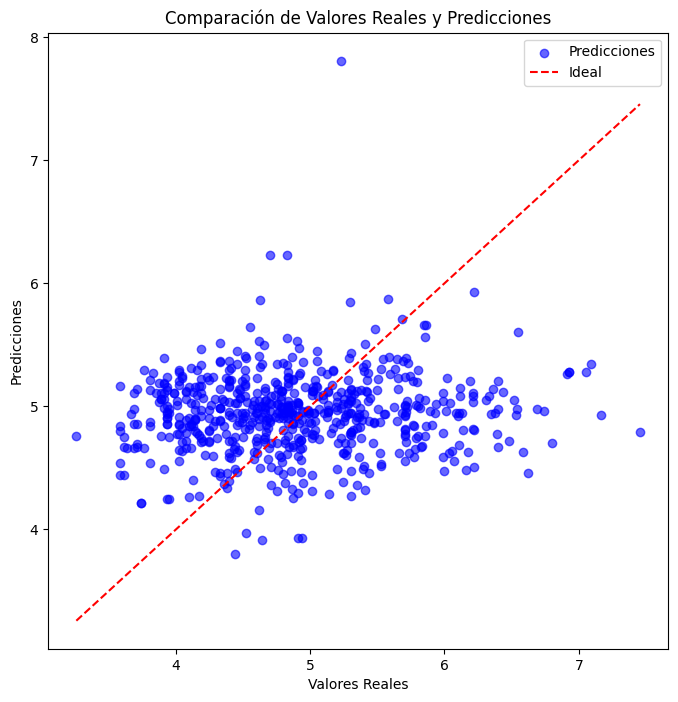

In [14]:
import matplotlib.pyplot as plt

# Generar predicciones
y_pred = best_model.predict(X_test)

# Comparación de reales vs predicciones
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.6, color="blue", label="Predicciones")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--", label="Ideal")
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.legend()
plt.title("Comparación de Valores Reales y Predicciones")
plt.show()




## **Resnet Fine-tuning**

In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Cargar el modelo base ResNet50
base_model = tf.keras.applications.ResNet50(
    include_top=False, weights="imagenet", input_shape=(224, 224, 3)
)

# Descongelar las últimas capas del modelo base
for layer in base_model.layers[:-20]:  # Congelar todas excepto las últimas 20 capas
    layer.trainable = False

# Añadir capas densas personalizadas
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)  # Regularización adicional
x = Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.3)(x)  # Más dropout para evitar sobreajuste
predictions = Dense(1, activation="linear")(x)  # Salida para regresión

# Crear el modelo completo
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo con AdamW y un scheduler dinámico
optimizer = AdamW(learning_rate=1e-3, weight_decay=1e-4)
model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

# Configurar data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest",
)

# Aplicar data augmentation solo al conjunto de entrenamiento
train_generator = train_datagen.flow(X_train, y_train, batch_size=64)
val_generator = ImageDataGenerator().flow(X_val, y_val, batch_size=64)

# Configurar callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)

# Entrenar el modelo
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1,
)

# Guardar el modelo entrenado
model.save("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/best_models/resnet50_optimized.keras")

# Evaluar el modelo en el conjunto de prueba
test_generator = ImageDataGenerator().flow(X_test, y_test, batch_size=32)
results = model.evaluate(test_generator, verbose=1)
print(f"Loss (MSE) en test: {results[0]:.4f}, MAE en test: {results[1]:.4f}")


Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - loss: 9.6662 - mae: 1.5715 - val_loss: 60.4833 - val_mae: 7.3485 - learning_rate: 0.0010
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 62s 651ms/step - loss: 4.4808 - mae: 0.7366 - val_loss: 10.9886 - val_mae: 2.6404 - learning_rate: 0.0010
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 40s 652ms/step - loss: 3.8001 - mae: 0.7252 - val_loss: 4.6979 - val_mae: 1.2757 - learning_rate: 0.0010
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 27s 647ms/step - loss: 3.2576 - mae: 0.6996 - val_loss: 5.1989 - val_mae: 1.5865 - learning_rate: 0.0010
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 40s 649ms/step - loss: 2.8841 - mae: 0.7184 - val_loss: 2.4482 - val_mae: 0.6115 - learning_rate: 0.0010
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 27s 654ms/step - loss: 2.4929 - mae: 0.6779 - val_loss: 2.3508 - val_mae: 0.6983 - learning_rate: 0.0010
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 27s 645ms/step - loss: 2.2281 - mae: 0.6777 - val_loss: 1.8363 - val_mae: 0.5591 - learning_rate: 0.0010


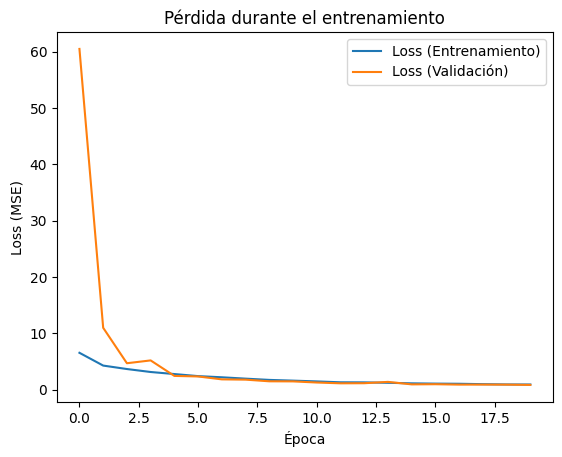

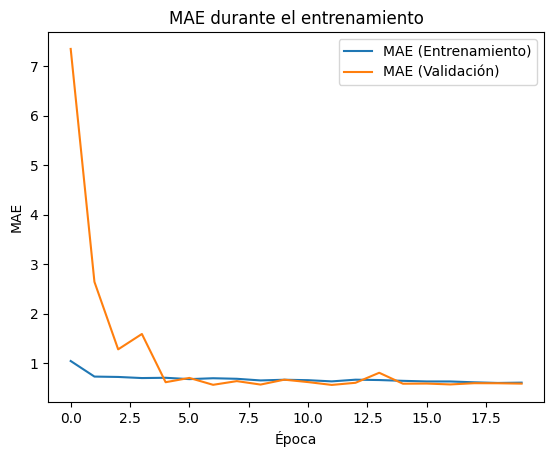

In [17]:
import matplotlib.pyplot as plt

# Graficar pérdida (MSE) durante el entrenamiento
plt.plot(history.history['loss'], label='Loss (Entrenamiento)')
plt.plot(history.history['val_loss'], label='Loss (Validación)')
plt.xlabel('Época')
plt.ylabel('Loss (MSE)')
plt.title('Pérdida durante el entrenamiento')
plt.legend()
plt.show()

# Graficar MAE durante el entrenamiento
plt.plot(history.history['mae'], label='MAE (Entrenamiento)')
plt.plot(history.history['val_mae'], label='MAE (Validación)')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.title('MAE durante el entrenamiento')
plt.legend()
plt.show()


In [18]:
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Cargar el modelo guardado
model = load_model("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/best_models/resnet50_optimized.keras")

# Generar predicciones en el conjunto de prueba
y_pred_test = model.predict(X_test)

# Evaluar métricas en escala logarítmica
mse = mean_squared_error(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print("Resultados en escala logarítmica:")
print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

# Evaluar métricas en escala original
y_test_real = np.expm1(y_test)
y_pred_test_real = np.expm1(y_pred_test)

mse_real = mean_squared_error(y_test_real, y_pred_test_real)
mae_real = mean_absolute_error(y_test_real, y_pred_test_real)
r2_real = r2_score(y_test_real, y_pred_test_real)

print("\nResultados en escala real:")
print(f"MSE: {mse_real:.2f}")
print(f"MAE: {mae_real:.2f}")
print(f"R²: {r2_real:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 235ms/step
Resultados en escala logarítmica:
MSE: 0.5670, MAE: 0.5922, R²: -0.0815

Resultados en escala real:
MSE: 39115.73
MAE: 109.57
R²: -0.2585


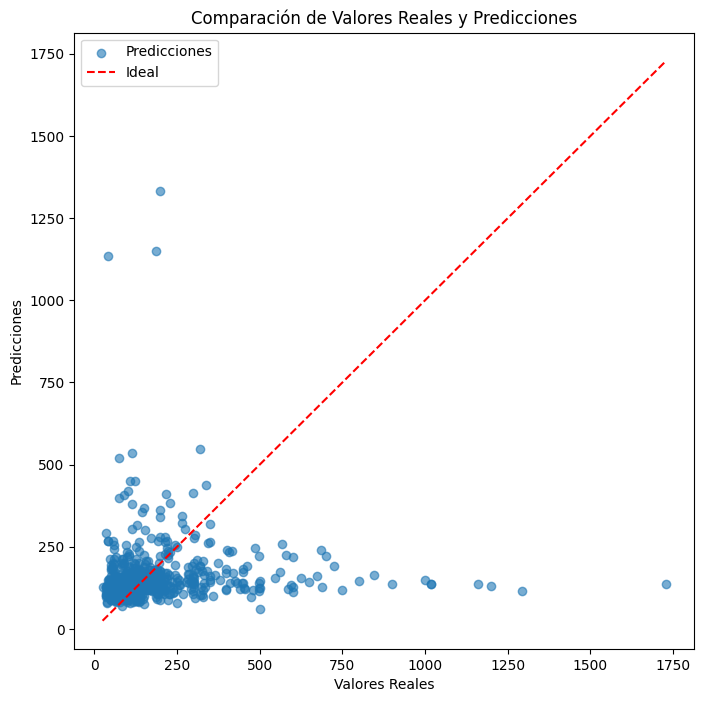

In [19]:
import matplotlib.pyplot as plt

# Scatter plot para comparar valores reales y predicciones
plt.figure(figsize=(8, 8))
plt.scatter(y_test_real, y_pred_test_real, alpha=0.6, label="Predicciones")
plt.plot([y_test_real.min(), y_test_real.max()], [y_test_real.min(), y_test_real.max()], 'r--', label="Ideal")
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Comparación de Valores Reales y Predicciones")
plt.legend()
plt.show()


**En la escala logarítmica:**
El MSE y el MAE están dentro de un rango aceptable, pero el
r2 muestra que el modelo no está capturando bien la varianza de los datos.

**En la escala real:**
El MSE y MAE son altos, lo que indica que las predicciones en la escala de precios originales tienen grandes desviaciones.

**r2:**
negativo implica que el modelo tiene dificultades para aproximarse a las verdaderas etiquetas en esta escala.

**Gráfica de predicciones vs. valores reales:**
Aunque la mayoría de los puntos están agrupados cerca de los valores reales, hay varios valores extremos que afectan el rendimiento.

**Distribución del error:**
El error en validación converge, pero puede haber un sobreajuste o una necesidad de más regularización.

**Intentaré reducir dimensiones de las imagenes por eficiencia computacional y probar con mas parametros sin tanta demora.**

In [21]:
import numpy as np
from tensorflow.image import resize

# Función para redimensionar imágenes
def resize_images(images, target_size=(128, 128)):
    return np.array([resize(image, target_size).numpy() for image in images])

# Cargar las imágenes actuales
X_train = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_train_normalized.npy")
X_val = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_val_normalized.npy")
X_test = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_test_normalized.npy")

# Redimensionar las imágenes a 128x128
X_train_resized = resize_images(X_train, target_size=(128, 128))
X_val_resized = resize_images(X_val, target_size=(128, 128))
X_test_resized = resize_images(X_test, target_size=(128, 128))

# Guardar las imágenes redimensionadas
np.save("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_train_128.npy", X_train_resized)
np.save("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_val_128.npy", X_val_resized)
np.save("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_test_128.npy", X_test_resized)

print("Imágenes redimensionadas y guardadas correctamente:")
print(f"Train: {X_train_resized.shape}, Val: {X_val_resized.shape}, Test: {X_test_resized.shape}")


Imágenes redimensionadas y guardadas correctamente:
Train: (2125, 128, 128, 3), Val: (376, 128, 128, 3), Test: (627, 128, 128, 3)


In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Cargar las imágenes redimensionadas y las etiquetas
X_train = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_train_128.npy")
X_val = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_val_128.npy")
X_test = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_test_128.npy")
y_train = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/y_train.npy")
y_val = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/y_val.npy")
y_test = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/y_test.npy")

# Configurar el modelo base (ResNet50)
base_model = tf.keras.applications.ResNet50(
    include_top=False, weights="imagenet", input_shape=(128, 128, 3)
)

# Descongelar las últimas capas del modelo base
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Añadir capas personalizadas
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.3)(x)
predictions = tf.keras.layers.Dense(1, activation="linear")(x)

# Compilar el modelo
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4),
              loss="mse", metrics=["mae"])

# Configurar data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest",
)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = ImageDataGenerator().flow(X_val, y_val, batch_size=32)

# Configurar callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)

# Entrenar el modelo
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

# Guardar el modelo entrenado
model.save("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/best_models/resnet50_128x128.keras")

# Evaluar el modelo
test_generator = ImageDataGenerator().flow(X_test, y_test, batch_size=32)
results = model.evaluate(test_generator, verbose=1)
print(f"Loss (MSE) en test: {results[0]:.4f}, MAE en test: {results[1]:.4f}")


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


67/67 ━━━━━━━━━━━━━━━━━━━━ 53s 361ms/step - loss: 7.8570 - mae: 1.3011 - val_loss: 11.3993 - val_mae: 2.6099 - learning_rate: 0.0010
Epoch 2/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - loss: 3.8358 - mae: 0.7555 - val_loss: 3.0705 - val_mae: 0.6981 - learning_rate: 0.0010
Epoch 3/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - loss: 2.9406 - mae: 0.7077 - val_loss: 3.3884 - val_mae: 1.1168 - learning_rate: 0.0010
Epoch 4/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 22s 161ms/step - loss: 2.3096 - mae: 0.6803 - val_loss: 1.7913 - val_mae: 0.5777 - learning_rate: 0.0010
Epoch 5/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 11s 152ms/step - loss: 1.9702 - mae: 0.6819 - val_loss: 1.8972 - val_mae: 0.7981 - learning_rate: 0.0010
Epoch 6/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - loss: 1.7498 - mae: 0.7152 - val_loss: 1.7108 - val_mae: 0.7673 - learning_rate: 0.0010
Epoch 7/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 20s 153ms/step - loss: 1.5409 - mae: 0.7135 - val_loss: 1.4377 - val_mae: 0.7048 - learning_rate: 0.0010
Epoch 8/3

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 182ms/step
Resultados en escala real:
MSE: 33228.95
MAE: 100.35
R²: -0.0691


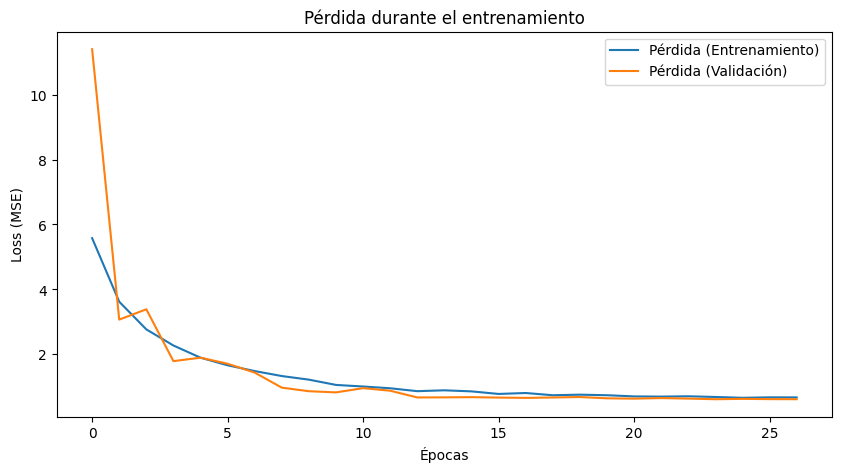

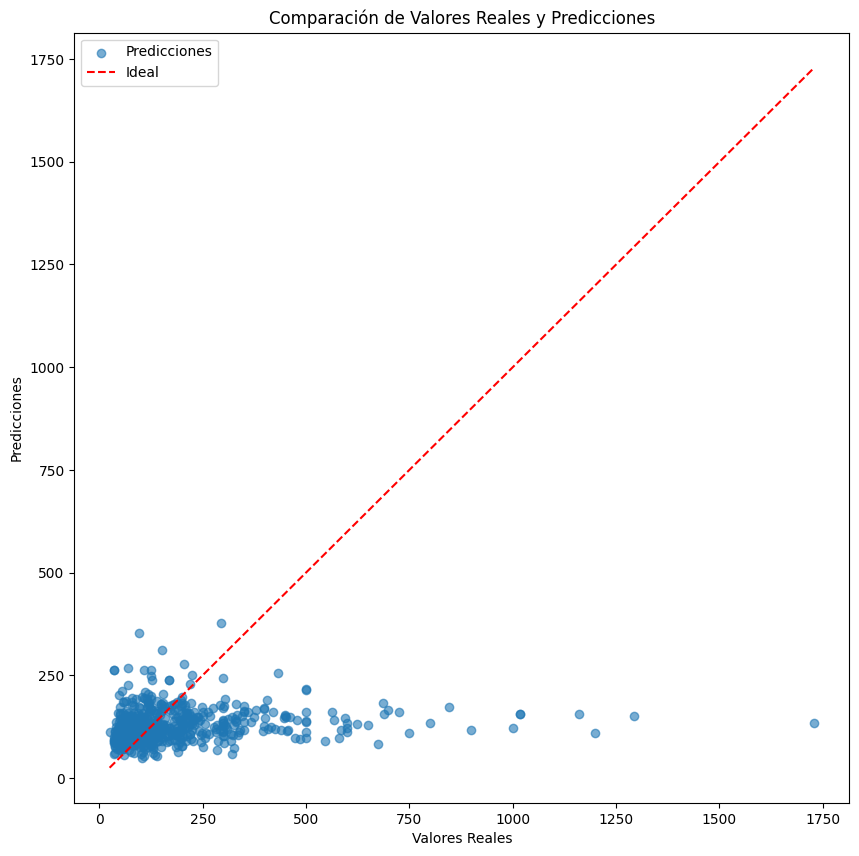

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Cargar el modelo entrenado
model = tf.keras.models.load_model("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/best_models/resnet50_128x128.keras")

# Generar predicciones
y_pred = model.predict(X_test)

# Transformar los valores reales y las predicciones a escala original (si usaste log1p anteriormente)
y_test_real = np.expm1(y_test)
y_pred_real = np.expm1(y_pred.flatten())

# Calcular métricas
mse = mean_squared_error(y_test_real, y_pred_real)
mae = mean_absolute_error(y_test_real, y_pred_real)
r2 = r2_score(y_test_real, y_pred_real)

print("Resultados en escala real:")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")

# Graficar las métricas durante el entrenamiento
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Pérdida (Entrenamiento)')
plt.plot(history.history['val_loss'], label='Pérdida (Validación)')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

# Comparar predicciones y valores reales
plt.figure(figsize=(10, 10))
plt.scatter(y_test_real, y_pred_real, alpha=0.6, label='Predicciones')
plt.plot([min(y_test_real), max(y_test_real)], [min(y_test_real), max(y_test_real)], color='red', linestyle='--', label='Ideal')
plt.title('Comparación de Valores Reales y Predicciones')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.legend()
plt.show()


**Análisis graficos**

La pérdida disminuye consistentemente en las primeras 10-15 épocas, lo cual es una señal positiva de aprendizaje.
La curva de validación es cercana a la de entrenamiento, lo que indica que no hay un problema significativo de sobreajuste.

Métricas en escala real:
**MSE: 33,228.95** es elevado para un modelo de predicción de precios, indicando un error promedio grande.

**MAE: 100.35** significa que, en promedio, las predicciones tienen un error absoluto de aproximadamente 100 unidades monetarias.

**R²: -0.0691** indica que el modelo no está explicando la variabilidad en los datos correctamente.

## **Seguriré con ajuste del dropout y añadir batch normalization** dropout 0.5

In [25]:
from tensorflow.keras.layers import BatchNormalization

# Añadir dropout y Batch Normalization al modelo
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Aumentar el dropout para evitar overfitting
x = Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)  # Añadir batch normalization después de la capa densa
x = Dropout(0.5)(x)  # Más dropout para regularización adicional
predictions = Dense(1, activation="linear")(x)  # Salida para regresión

# Crear el modelo completo con las capas actualizadas
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

print("Modelo actualizado con Dropout y Batch Normalization.")


Modelo actualizado con Dropout y Batch Normalization.


**Ampliaré el data augmentation para aumentar la diversidad de las imágenes de entrenamiento y reducir el sobreajuste.**

In [26]:
# Configurar un esquema más agresivo de data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=30,  # Incrementar la rotación
    width_shift_range=0.2,  # Aumentar el rango de desplazamiento horizontal
    height_shift_range=0.2,  # Aumentar el rango de desplazamiento vertical
    shear_range=0.2,  # Incrementar el rango de corte
    zoom_range=0.2,  # Aumentar el rango de zoom
    horizontal_flip=True,  # Permitir volteo horizontal
    fill_mode="nearest",  # Rellenar los bordes
)

# Aplicar data augmentation solo al conjunto de entrenamiento
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

# Mantener validación y prueba sin augmentación
val_generator = ImageDataGenerator().flow(X_val, y_val, batch_size=32)

print("Data augmentation agresivo configurado.")


Data augmentation agresivo configurado.


## **Incrementaré el dropout para regularización adicional** dropout 0.4

In [27]:
from tensorflow.keras.layers import BatchNormalization

# Ajustar el modelo con más Dropout y Batch Normalization
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)  # Incrementar el dropout
x = Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)  # Añadir batchnNormalization
x = Dropout(0.4)(x)  # Incrementar otro dropout
predictions = Dense(1, activation="linear")(x)  # Salida para regresión

# Crear el modelo actualizado
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

print("Modelo actualizado con Dropout adicional y Batch Normalization.")


Modelo actualizado con Dropout adicional y Batch Normalization.


## **Esquema más agresivo de Data Augmentation**

In [28]:
# Configurar Data Augmentation aún más agresivo
train_datagen = ImageDataGenerator(
    rotation_range=40,  # Rotación más alta
    width_shift_range=0.3,  # Mayor desplazamiento horizontal
    height_shift_range=0.3,  # Mayor desplazamiento vertical
    shear_range=0.3,  # Más cizallamiento
    zoom_range=0.3,  # Más zoom
    horizontal_flip=True,  # Mantener volteo horizontal
    brightness_range=[0.8, 1.2],  # Variación de brillo
    channel_shift_range=50.0,  # Alterar colores
    fill_mode="nearest",  # Rellenar huecos
)

# Aplicar Data Augmentation solo al conjunto de entrenamiento
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

# Mantener el generador de validación sin augmentación
val_generator = ImageDataGenerator().flow(X_val, y_val, batch_size=32)

print("Esquema más agresivo de Data Augmentation configurado.")


Esquema más agresivo de Data Augmentation configurado.


## **Pruebas en modelo**

In [29]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Configurar callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)

# Entrenar el modelo
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1,
)

# Guardar el modelo entrenado
model.save("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/best_models/resnet50_dropout_batchnorm.keras")

# Evaluar en el conjunto de prueba
test_generator = ImageDataGenerator().flow(X_test, y_test, batch_size=32)
results = model.evaluate(test_generator, verbose=1)
print(f"Loss (MSE) en test: {results[0]:.4f}, MAE en test: {results[1]:.4f}")


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


67/67 ━━━━━━━━━━━━━━━━━━━━ 42s 370ms/step - loss: 26.6815 - mae: 4.5819 - val_loss: 300.8126 - val_mae: 15.6592 - learning_rate: 0.0010
Epoch 2/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 14s 188ms/step - loss: 13.4783 - mae: 2.9639 - val_loss: 13031.7656 - val_mae: 107.3206 - learning_rate: 0.0010
Epoch 3/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 21s 198ms/step - loss: 5.8938 - mae: 1.2972 - val_loss: 139.6336 - val_mae: 10.7265 - learning_rate: 0.0010
Epoch 4/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 19s 180ms/step - loss: 4.0549 - mae: 0.8873 - val_loss: 5.1110 - val_mae: 1.5048 - learning_rate: 0.0010
Epoch 5/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 181ms/step - loss: 3.9737 - mae: 0.9099 - val_loss: 51.4831 - val_mae: 6.2705 - learning_rate: 0.0010
Epoch 6/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 3.3366 - mae: 0.8553
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 169ms/step - loss: 3.3361 - mae: 0.8554 - val_loss: 16.5674 - val_mae: 3.4093 - learning_rate

## **Evaluemos el modelo con sus cambios**

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 4.9791 - mae: 1.4811
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 243ms/step
Resultados en escala logarítmica:
MSE: 2.8626, MAE: 1.4670, R²: -4.4597

Resultados en escala real:
MSE: 492355.37, MAE: 523.10, R²: -14.8409


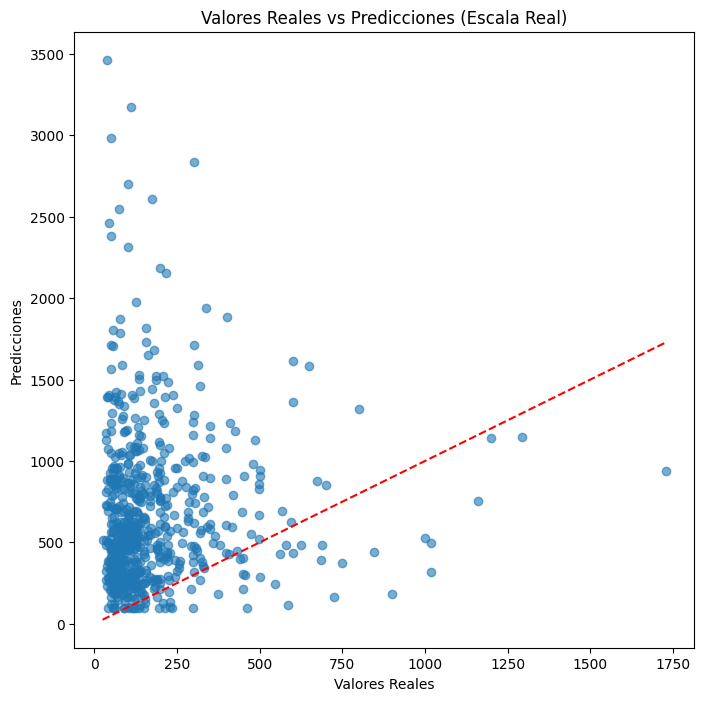

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Evaluar el modelo en el conjunto de prueba
test_generator = ImageDataGenerator().flow(X_test, y_test, batch_size=32)
results = model.evaluate(test_generator, verbose=1)

# Calcular métricas en escala logarítmica y real
y_test_pred = model.predict(test_generator)
y_test_real = np.expm1(y_test)  # Devolver las etiquetas a escala original
y_test_pred_real = np.expm1(y_test_pred)

# Escala logarítmica
mse_log = mean_squared_error(y_test, y_test_pred)
mae_log = mean_absolute_error(y_test, y_test_pred)
r2_log = r2_score(y_test, y_test_pred)

# Escala real
mse_real = mean_squared_error(y_test_real, y_test_pred_real)
mae_real = mean_absolute_error(y_test_real, y_test_pred_real)
r2_real = r2_score(y_test_real, y_test_pred_real)

print("Resultados en escala logarítmica:")
print(f"MSE: {mse_log:.4f}, MAE: {mae_log:.4f}, R²: {r2_log:.4f}")
print("\nResultados en escala real:")
print(f"MSE: {mse_real:.2f}, MAE: {mae_real:.2f}, R²: {r2_real:.4f}")

# Graficar predicciones vs valores reales
plt.figure(figsize=(8, 8))
plt.scatter(y_test_real, y_test_pred_real, alpha=0.6)
plt.plot([y_test_real.min(), y_test_real.max()], [y_test_real.min(), y_test_real.max()], 'r--')
plt.title('Valores Reales vs Predicciones (Escala Real)')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.show()


**El modelo tiene problemas claros de generalizacion, los valores de r2 negativos indican que esta funcionando peor, volveré el modeloo ResNet50Fien-Tuned para optimizacion con Bayesian.**



In [10]:
!pip install keras-tuner

In [11]:
import numpy as np

# Cargar imágenes redimensionadas a 128x128
X_train = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_train_128.npy")
X_val = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_val_128.npy")
X_test = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/imgs_test_128.npy")

# Cargar etiquetas
y_train = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/y_train.npy")
y_val = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/y_val.npy")
y_test = np.load("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/data/y_test.npy")

# Verificar shapes
print(f"Imágenes de entrenamiento: {X_train.shape}, Etiquetas: {y_train.shape}")
print(f"Imágenes de validación: {X_val.shape}, Etiquetas: {y_val.shape}")
print(f"Imágenes de prueba: {X_test.shape}, Etiquetas: {y_test.shape}")


Imágenes de entrenamiento: (2125, 128, 128, 3), Etiquetas: (2125,)
Imágenes de validación: (376, 128, 128, 3), Etiquetas: (376,)
Imágenes de prueba: (627, 128, 128, 3), Etiquetas: (627,)


In [23]:
import keras_tuner as kt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# Definir la función del modelo para búsqueda bayesiana
def build_model(hp):
    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        weights="imagenet",
        input_shape=(128, 128, 3)
    )
    # Ajustar el número de capas a descongelar
    unfreeze_layers = hp.Int("unfreeze_layers", min_value=5, max_value=30, step=5)
    for layer in base_model.layers[:-unfreeze_layers]:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(hp.Choice("dropout_rate", values=[0.3, 0.4, 0.5]))(x)
    x = Dense(
        hp.Int("dense_units", min_value=128, max_value=512, step=64),
        activation="relu",
        kernel_regularizer=tf.keras.regularizers.l2(hp.Choice("l2_reg", [1e-4, 1e-3]))
    )(x)
    predictions = Dense(1, activation="linear")(x)

    # Implementar Exponential Decay
    initial_lr = hp.Choice("initial_learning_rate", values=[1e-2, 1e-3, 1e-4])
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_lr,
        decay_steps=100000,
        decay_rate=0.9,
        staircase=True
    )

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(
        optimizer=Adam(learning_rate=lr_schedule),
        loss="mse",
        metrics=["mae"]
    )
    return model

# Definir el tuner para la búsqueda bayesiana
tuner = kt.BayesianOptimization(
    build_model,
    objective="val_loss",
    max_trials=5,  # Reducir la cantidad de trials para optimizar el tiempo
    directory="/content/drive/MyDrive/Deep_Learning_2024/Notebooks/tuner",
    project_name="resnet50_optimization"
)

# Configurar data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)
train_generator = train_datagen.flow(X_train, y_train, batch_size=64)
val_generator = ImageDataGenerator().flow(X_val, y_val, batch_size=64)

# Configurar callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)

# Ejecutar la búsqueda
tuner.search(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # Reducir el número de épocas para optimizar el tiempo
    callbacks=[early_stopping, lr_scheduler],
    verbose=1,
)

# Mostrar los mejores hiperparámetros encontrados
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Mejores hiperparámetros:")
print(f"- Initial Learning Rate: {best_hps.get('initial_learning_rate')}")
print(f"- Dropout rate: {best_hps.get('dropout_rate')}")
print(f"- Dense units: {best_hps.get('dense_units')}")
print(f"- L2 Regularization: {best_hps.get('l2_reg')}")
print(f"- Unfreeze layers: {best_hps.get('unfreeze_layers')}")


Trial 5 Complete [00h 26m 31s]

Best val_loss So Far: 0.7287178635597229
Total elapsed time: 02h 37m 36s
Mejores hiperparámetros:
- Initial Learning Rate: 0.01
- Dropout rate: 0.4
- Dense units: 320
- L2 Regularization: 0.0001
- Unfreeze layers: 10


## **Obtener el mejor modelo del tuner, evaluar el mejor con los parametros del tuner**

In [24]:
best_model = tuner.get_best_models(num_models=1)[0]


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 1 variables whereas the saved optimizer has 33 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [25]:
test_generator = ImageDataGenerator().flow(X_test, y_test, batch_size=64)
results = best_model.evaluate(test_generator, verbose=1)
print(f"Loss (MSE) en test: {results[0]:.4f}, MAE en test: {results[1]:.4f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step - loss: 0.7568 - mae: 0.6232
Loss (MSE) en test: 0.7720, MAE en test: 0.6298


In [31]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Cargar los mejores hiperparámetros encontrados por el tuner
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Construir el modelo con los mejores hiperparámetros
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(128, 128, 3)
)
unfreeze_layers = best_hps.get("unfreeze_layers")
for layer in base_model.layers[:-unfreeze_layers]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(best_hps.get("dropout_rate"))(x)
x = Dense(
    best_hps.get("dense_units"),
    activation="relu",
    kernel_regularizer=tf.keras.regularizers.l2(best_hps.get("l2_reg"))
)(x)
predictions = Dense(1, activation="linear")(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Configurar el optimizador con Exponential Decay
initial_lr = best_hps.get("initial_learning_rate")
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=100000,
    decay_rate=0.9,
    staircase=True
)
optimizer = Adam(learning_rate=lr_schedule)

# Compilar el modelo
model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

# Configurar callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

# Reentrenar el modelo
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,  # Reducir el número de épocas
    batch_size=64,  # Tamaño de batch más grande
    callbacks=[early_stopping],
    verbose=1,
)

# Guardar el modelo entrenado
model.save("/content/drive/MyDrive/Deep_Learning_2024/Notebooks/best_models/resnet50_optimized_final.keras")

# Evaluar el modelo en el conjunto de prueba
results = model.evaluate(test_generator, verbose=1)
print(f"Loss (MSE) en test: {results[0]:.4f}, MAE en test: {results[1]:.4f}")


Epoch 1/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 209s 6s/step - loss: 139.5165 - mae: 6.8843 - val_loss: 23.5256 - val_mae: 4.7770
Epoch 2/5
14/34 ━━━━━━━━━━━━━━━━━━━━ 1:43 5s/step - loss: 22.1207 - mae: 4.6167

KeyboardInterrupt: 


Pude llegar solo hasta aqui, los tiempos de entrenamiento se alargaron mucho y no alcance a avanzar mas. Igualmente hago la entrega por que me interesa mucho saber sobre el proceso de todo lo que he hecho hasta el momento.

Gaste mucho tiempo en Machine Learning y me gustaria tambien tener tu opinion de si lo que hice tiene un mejor workflow o si me complique mucho por que todavia

## **Análisis de mejor modelo**



# **3. Fusión de modelos: Early Fusion**

# **3b. Late-Fusión de modelos**